In [27]:
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 16})
from matplotlib.offsetbox import AnchoredText
import pickle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from plots import scatter_interpolate
from mda import normalize_df
import seaborn as sns
from shapely.geometry import Point

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
## laad gpkg will considered tracks
gdf = gpd.read_file(r"../gis/gpkg/STORM_NA_R4_IN_v7.gpkg")
## load time series of the tracks
dfall = pd.read_pickle(r"../data/STORM/processed/STORM_NA_R4_InOut_v7.pkl")
## load reduced dataset (input of MDA)
dfpnt = pd.read_pickle(r'../data/STORM/processed/STORM_NA_R4_In_pnt_v7.pkl')
## load clusters
dfcl = pd.read_pickle(r"../data/STORM/processed/STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000.pkl")

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [5]:
dfpnt.describe().T

,count,mean,std,min,25%,50%,75%,max
year,9898.0,4975.200950,2890.861990,0.000000e+00,2490.000000,4949.500000,7497.750000,9999.000000
month,9898.0,8.488584,1.195171,6.000000e+00,8.000000,9.000000,9.000000,11.000000
yr_tc_number,9898.0,5.295514,3.851290,0.000000e+00,2.000000,5.000000,8.000000,22.000000
time_step_at_min_press,9898.0,21.320974,18.602323,2.000000e+00,8.000000,16.000000,29.000000,188.000000
time_step_at_min_distNC,9898.0,27.905435,27.592364,0.000000e+00,8.000000,17.000000,43.000000,234.000000
lat_at_min_press,9898.0,30.460083,6.853791,8.300000e+00,27.500000,31.300000,34.300000,59.900000
lon_at_min_press,9898.0,-69.921570,11.393120,-9.860000e+01,-76.700000,-73.200000,-67.325000,-1.200000
lat_at_min_distNC,9898.0,33.982542,1.824335,2.930000e+01,32.700000,34.300000,35.200000,40.100000
lon_at_min_distNC,9898.0,-75.826551,2.548399,-8.290000e+01,-77.600000,-75.600000,-73.900000,-70.800000
min_press_at_min_distNC,9898.0,982.081921,19.254992,9.035000e+02,970.800000,988.000000,997.400000,1010.400000


In [6]:
index = [0 if 'trajectory' in x else 1 for x in dfpnt.columns[:-1]] ## drop length

In [7]:
dfcl.describe().T

,count,mean,std,min,25%,50%,75%,max
lat_at_min_distNC,1000.0,33.655600,2.156200,2.940000e+01,31.900000,33.800000,35.100000,40.100000
lon_at_min_distNC,1000.0,-75.655900,2.454639,-8.270000e+01,-77.200000,-75.600000,-73.800000,-70.900000
min_press_at_min_distNC,1000.0,982.560343,22.441501,9.058000e+02,969.325000,992.550000,999.712235,1010.000000
rad_to_max_ws_at_min_distNC,1000.0,58.328296,33.219246,9.260000e+00,34.991225,49.504688,74.080002,172.235995
forward_speed_at_min_distNC,1000.0,25.341045,17.864546,2.970937e+00,12.458277,22.113303,33.420303,112.175674
landfall,1000.0,0.581000,0.493642,0.000000e+00,0.000000,1.000000,1.000000,1.000000
trajectory_in_roi,1000.0,198.426075,130.233803,0.000000e+00,51.340192,270.000000,315.000000,354.805571
mean_trajectory_roi,1000.0,175.464806,130.286111,1.055327e-14,43.790145,163.265898,308.996845,359.671571
mean_curvature_roi,1000.0,0.604101,0.788873,0.000000e+00,0.080025,0.225760,0.810658,3.545342
duration,1000.0,168.045000,126.137947,2.400000e+01,63.000000,138.000000,243.000000,828.000000


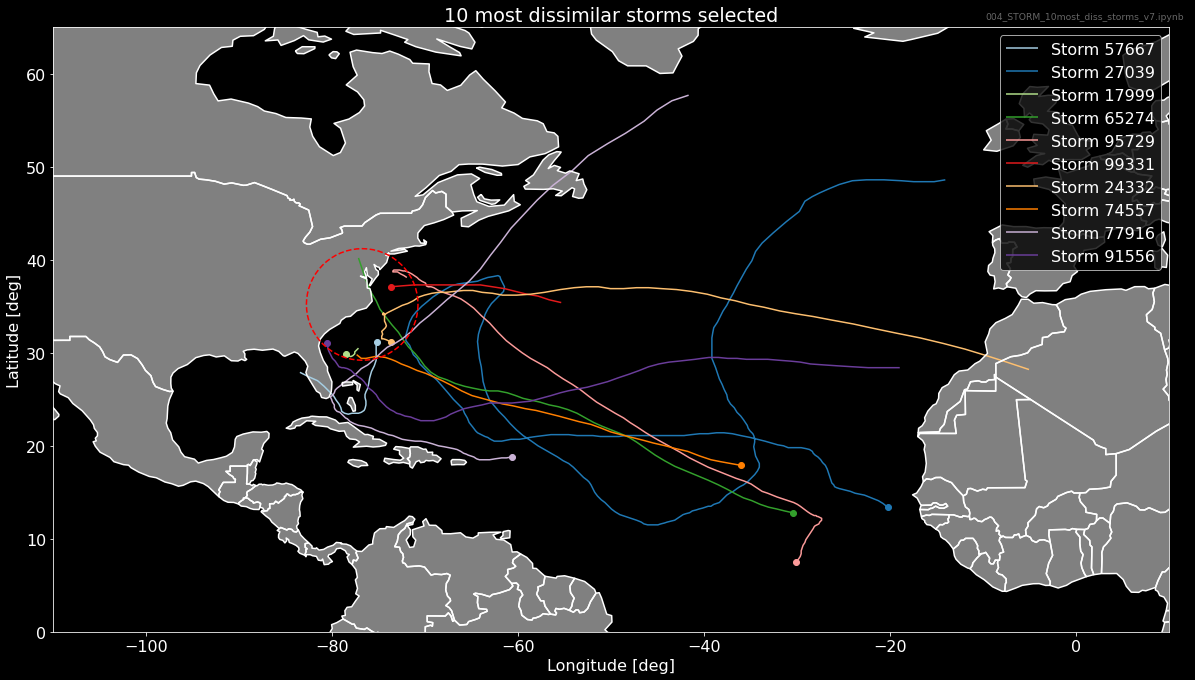

In [31]:
# lab = [f'Storm {sid:0.0f}: {x:03d} pnts' for sid, x in zip(dfcl['tc_number'][:10], dfcl['npoints'][:10])]
lab = [f'Storm {sid:0.0f}' for sid, x in zip(dfcl['tc_number'][:10], dfcl['npoints'][:10])]
nc = Point((-76.8, 35.2))
box = gpd.GeoDataFrame(geometry = [nc.buffer(6)])

fig, ax = plt.subplots(figsize = (20, 20))
# ax.plot([-76.8], [35.2], color = 'k', marker = '*', ms = 20, alpha = 0.2)

cm = plt.colormaps.get('Paired')
for ig, g in enumerate(dfcl['tc_number'][:10]):
    gdf[gdf['tc_number'] == g].plot(ax = ax, legend = True, color = cm(ig))
    ax.scatter([gdf[gdf['tc_number'] == g].geometry.iloc[0].coords[0][0]],
                [gdf[gdf['tc_number'] == g].geometry.iloc[0].coords[0][1]], color = cm(ig), label = '_nolegend_')
world.plot(ax = ax, color = 'grey')
world.boundary.plot(ax = ax, color = 'w')
box.boundary.plot(ax = ax, color = 'r', ls = '--')

ax.set_xlim([-110, 10])
ax.set_ylim([0, 65])
ax.set_aspect('equal')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title('10 most dissimilar storms selected')

ax.legend(lab, frameon = True)
text = AnchoredText(nb_name, 'upper right',frameon = False, borderpad = -2, prop=dict(fontsize = 'xx-small', alpha = 0.4))
ax.add_artist(text)

In [37]:
dfcl.head()

,lat_at_min_distNC,lon_at_min_distNC,min_press_at_min_distNC,rad_to_max_ws_at_min_distNC,forward_speed_at_min_distNC,landfall,trajectory_in_roi,mean_trajectory_roi,mean_curvature_roi,duration,lat_gen,lon_gen,index_cluster,weight,npoints,tc_number
0,31.2,-75.2,999.804132,37.040001,29.046809,1.0,194.036243,183.495849,0.180532,99.0,31.2,-75.2,5250,0.000102,1,57667.0
1,33.3,-71.7,947.700000,30.626958,26.617725,0.0,15.945396,28.405243,0.134638,828.0,13.4,-20.3,2454,0.000102,1,27039.0
2,30.5,-77.2,1001.600000,166.679993,9.780792,0.0,0.000000,57.804361,2.802478,48.0,29.9,-78.5,1652,0.000102,1,17999.0
3,35.6,-75.3,992.200000,171.207108,35.431070,1.0,327.994617,331.926563,0.047634,168.0,12.8,-30.5,5926,0.000204,2,65274.0
4,38.7,-73.5,995.600000,101.649548,3.700357,0.0,270.000000,168.718546,3.545342,315.0,7.5,-30.2,8556,0.000102,1,95729.0


In [68]:
dfpnt_mean = normalize_df(dfpnt.iloc[:, :-1], index).mean(axis = 0)
dfpnt_std = normalize_df(dfpnt.iloc[:, :-1], index).std(axis = 0)

dfcl_dist = pd.DataFrame(index = dfcl.index, columns = dfcl.columns[:-4])

for col in dfcl_dist.columns:
    dfcl_dist[col] = np.sqrt((dfcl[col] - dfpnt_mean[col])**2) / dfpnt_std[col]
    
dfcl_dist['tc_number'] = dfcl['tc_number']


dfext = pd.DataFrame(index = dfcl_dist['tc_number'], columns = [f'Ext{x:02d}' for x in range(1, len(dfcl_dist.columns[:-1]) + 1)])
for i, j in enumerate(dfcl_dist.index):
    dfext.iloc[i, :] = dfcl_dist.iloc[[i], :-1].T.sort_values(by = [i], ascending = False).index

In [70]:
dfext.to_csv(r"../data/STORM/processed/STORM_NA_R4_In_pnt_v7_MDAvec_12params_1000_extremevars.csv")

In [25]:
def sca(x, y):
    '''
    '''
    cm = plt.colormaps.get('Paired')
    ix = list(dfcl.columns).index(x)
    iy = list(dfcl.columns).index(y)

    fig, ax = plt.subplots(figsize = (12, 8))
    ax.scatter(dfpnt[x], dfpnt[y], alpha = 0.2, c = 'w')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    for i, index in enumerate(dfcl.index[:10]):
        ax.scatter([dfcl.iloc[i, ix]], [dfcl.iloc[i, iy]], color = cm(i), s = 100);
    ax.grid(True, alpha = 0.4)
    return ax

Text(0, 0.5, 'Forward speed at point with min distance to NC [km/hr]')

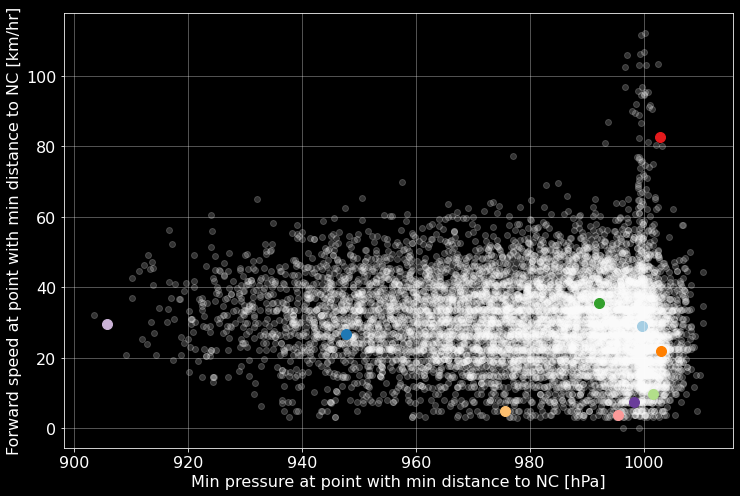

In [32]:
ax = sca('min_press_at_min_distNC', 'forward_speed_at_min_distNC')
ax.set_xlabel('Min pressure at point with min distance to NC [hPa]')
ax.set_ylabel('Forward speed at point with min distance to NC [km/hr]')